In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
config_path = Path("../configs/path.yaml")
with open(config_path, 'r') as f:
    path_config = yaml.safe_load(f)

In [3]:
df_item_price = pd.read_csv(path_config["data_path"]["master"]["item_price"])
df_sale_records = pd.read_csv(path_config["data_path"]["master"]["sale_records"])
df_items = pd.read_csv(path_config["data_path"]["master"]["items"])
df_regions = pd.read_csv(path_config["data_path"]["master"]["regions"])
df_stores = pd.read_csv(path_config["data_path"]["master"]["stores"])

## Merge data

In [4]:
def join_data(df_stores, df_regions, df_sale_records):
    
    # store_region
    df_store_region = (
        df_stores.merge(df_regions, left_on="region", right_on="name" ,how='left')
        .drop("name_y", axis=1)
        .rename(columns={"name_x": "store"})
    )

    df_sale = df_sale_records.merge(df_store_region, on="store", how="left")

    return df_sale

In [94]:
df_sale = join_data(df_stores, df_regions, df_sale_records)
df_sale.head()

,date,day_of_week,week_of_year,store,item,sales,total_sales_amount,item_price,region
0,2017-01-01,SUN,52,chiba,apple_juice,29,3480,120,east
1,2017-01-01,SUN,52,chiba,beer,15,3000,200,east
2,2017-01-01,SUN,52,chiba,coffee,26,5200,200,east
3,2017-01-01,SUN,52,chiba,fruit_juice,26,3900,150,east
4,2017-01-01,SUN,52,chiba,milk,38,4940,130,east


In [6]:
df_sale.shape

(182600, 9)

In [7]:
df_sale["week_of_year"].nunique()

53

## Quick visualization

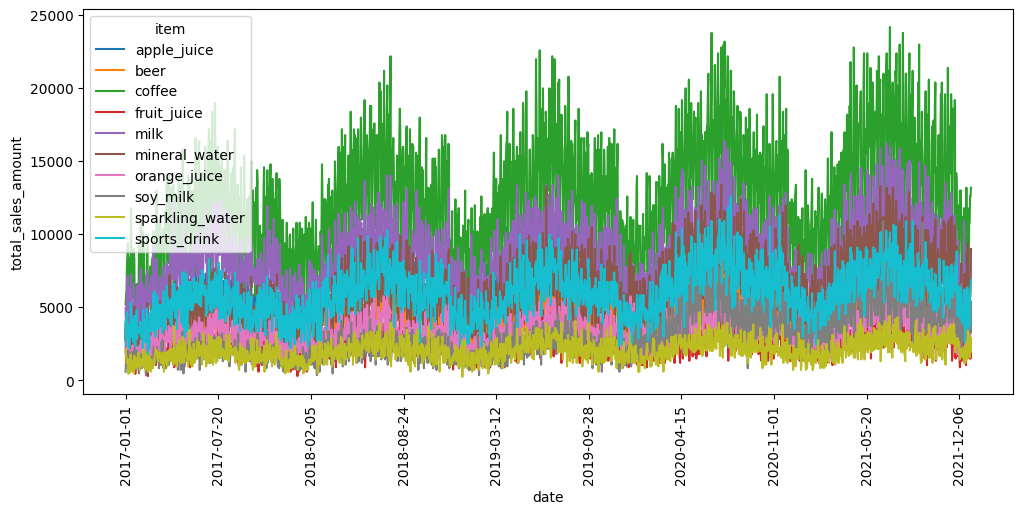

In [8]:
select_store = 'chiba'
tick_range = 20_000

fig, ax =plt.subplots(figsize=(12,5))
sns.lineplot(
    data=df_sale.query("store == @select_store"),
    x="date",
    y="total_sales_amount",
    hue="item",
    ax=ax
)
xticks = df_sale["date"][::tick_range].values
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=90);

In [6]:
# df_sale.query("store=='chiba' & item=='apple_juice' & week_of_year==1")

## Preprocess

In [9]:
def convert2date(df_sale):
    df_sale = df_sale.assign(date=lambda df: pd.to_datetime(df["date"], format="%Y-%m-%d"))\
        .sort_values(["store", "item", "week_of_year", "date"])
    return df_sale

In [97]:
def drop_cols(df_sale,unuse_cols):
    return df_sale.drop(unuse_cols, axis=1)

In [278]:
unuse_cols = ["sales", "item_price", "week_of_year"]
df_sale_intern = convert2date(df_sale)
df_sale_preprocessed = drop_cols(df_sale_intern,unuse_cols)

In [279]:
df_sale_preprocessed.describe(include="all", datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,182600,NaN,NaN,NaN,2019-07-02 11:59:59.999999744,2017-01-01 00:00:00,2018-04-02 00:00:00,2019-07-02 12:00:00,2020-10-01 00:00:00,2021-12-31 00:00:00,NaN
day_of_week,182600,7,MON,26100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,182600,10,chiba,18260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item,182600,10,apple_juice,18260,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_sales_amount,182600.0,NaN,NaN,NaN,7080.494469,0.0,3480.0,5800.0,9240.0,42000.0,4902.944451
region,182600,3,east,91300,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
train_valid_date = '2021-11-30'
train_date = '2021-7-30'

df_train_valid = df_sale_preprocessed.query("date <= @train_valid_date")
df_test = df_sale_preprocessed.query("date > @train_valid_date")

df_train = df_train_valid.query("date <= @train_date")
df_valid = df_train_valid.query("date > @train_date")

## Lag features

In [285]:
df_train.shape

(167200, 6)

In [286]:
df_test.shape

(3100, 6)

In [287]:
df_valid.shape

(12300, 6)

In [288]:
gp_keys = ["store", "item"]
TARGET = "total_sales_amount"
def make_lag(df, shift_day):
    return df.groupby(gp_keys)[TARGET]\
        .transform(lambda x: x.shift(shift_day)).astype(np.float16)

In [290]:
for i in range(1,22):
    df_train = df_train.assign(**{f"sale_lag_{i}": make_lag(df_train, shift_day=i)})
    df_valid = df_valid.assign(**{f"sale_lag_{i}": make_lag(df_valid, shift_day=i)})
    df_test = df_test.assign(**{f"sale_lag_{i}": make_lag(df_test, shift_day=i)})

## Modelling

In [226]:
# !pip install lightgbm

In [291]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
# from sklearn.pipeline import Pipeline

In [292]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.5,
    'subsample_freq': 1,
    'learning_rate': 0.015,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'feature_fraction': 0.5,
    'max_bin': 100,
    'n_estimators': 3000,
    'boost_from_average': False,
    'verbose': -1
} 

In [293]:
STORES = [store for store in df_sale["store"].unique()]

In [294]:
STORES

['chiba',
 'ginza',
 'kobe',
 'morioka',
 'nagoya',
 'osaka',
 'sendai',
 'shinjuku',
 'ueno',
 'yokohama']

In [295]:
select_store = 'chiba'
select_item = 'apple_juice'
train_y = df_train.query("store == @select_store")["total_sales_amount"]
train_x = df_train.query("store == @select_store").drop("total_sales_amount", axis=1).select_dtypes(exclude=["datetime", "object"])
valid_y = df_valid.query("store == @select_store")["total_sales_amount"]
valid_x = df_valid.query("store == @select_store").drop("total_sales_amount", axis=1).select_dtypes(exclude=["datetime", "object"])

In [296]:
train_data = lgb.Dataset(train_x, train_y)
valid_data = lgb.Dataset(valid_x, valid_y)

In [297]:
estimator = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[valid_data]
)

/Users/thaihanguyen/Desktop/projects/demand_forcast_mlsys/.venv/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [298]:
display(
    pd.DataFrame({'name':estimator.feature_name(),
                  'imp':estimator.feature_importance()}).sort_values('imp',ascending=False)
)

,name,imp
0,sale_lag_1,4081
20,sale_lag_21,4022
6,sale_lag_7,3998
1,sale_lag_2,3795
3,sale_lag_4,3620
2,sale_lag_3,3588
16,sale_lag_17,3579
8,sale_lag_9,3547
17,sale_lag_18,3537
13,sale_lag_14,3522


## Prediction

In [308]:
test_y = df_test.query("store == @select_store")["total_sales_amount"]
test_x = df_test.query("store == @select_store").drop("total_sales_amount", axis=1).select_dtypes(exclude=["datetime", "object"])

In [309]:
prediction = estimator.predict(test_x)

In [310]:
print(mean_squared_error(test_y, prediction))
print(r2_score(test_y, prediction))

1913312.9675745356
0.730270251125329


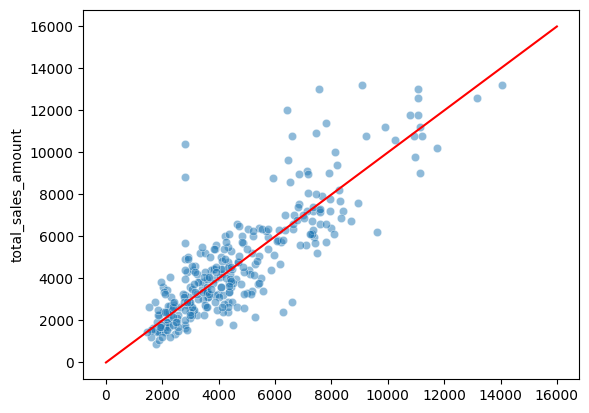

In [313]:
fig, ax = plt.subplots()
sns.scatterplot(x=prediction, y=test_y, alpha=0.5, ax=ax)
ax.plot([0,16_000], [0, 16_000], "r");

In [315]:
df_test_chiba = df_test.query("store == @select_store")[["date", "item", "total_sales_amount"]]

In [317]:
df_test_chiba["prediction"] = prediction

In [318]:
df_test_chiba

,date,item,total_sales_amount,prediction
179500,2021-12-01,apple_juice,4920,2813.862776
179600,2021-12-02,apple_juice,3960,4624.905347
179700,2021-12-03,apple_juice,4200,4399.264127
179800,2021-12-04,apple_juice,2880,4334.904318
179900,2021-12-05,apple_juice,3120,3628.964426
...,...,...,...,...
182109,2021-12-27,sports_drink,5720,4275.852940
182209,2021-12-28,sports_drink,3770,5427.720873
182309,2021-12-29,sports_drink,6240,5221.097556
182409,2021-12-30,sports_drink,6370,5741.427960


In [321]:
item_lst = [item for item in df_items["name"]]

In [323]:
len(item_lst)

10

In [330]:
item_lst

['fruit_juice',
 'apple_juice',
 'orange_juice',
 'sports_drink',
 'coffee',
 'milk',
 'mineral_water',
 'sparkling_water',
 'soy_milk',
 'beer']

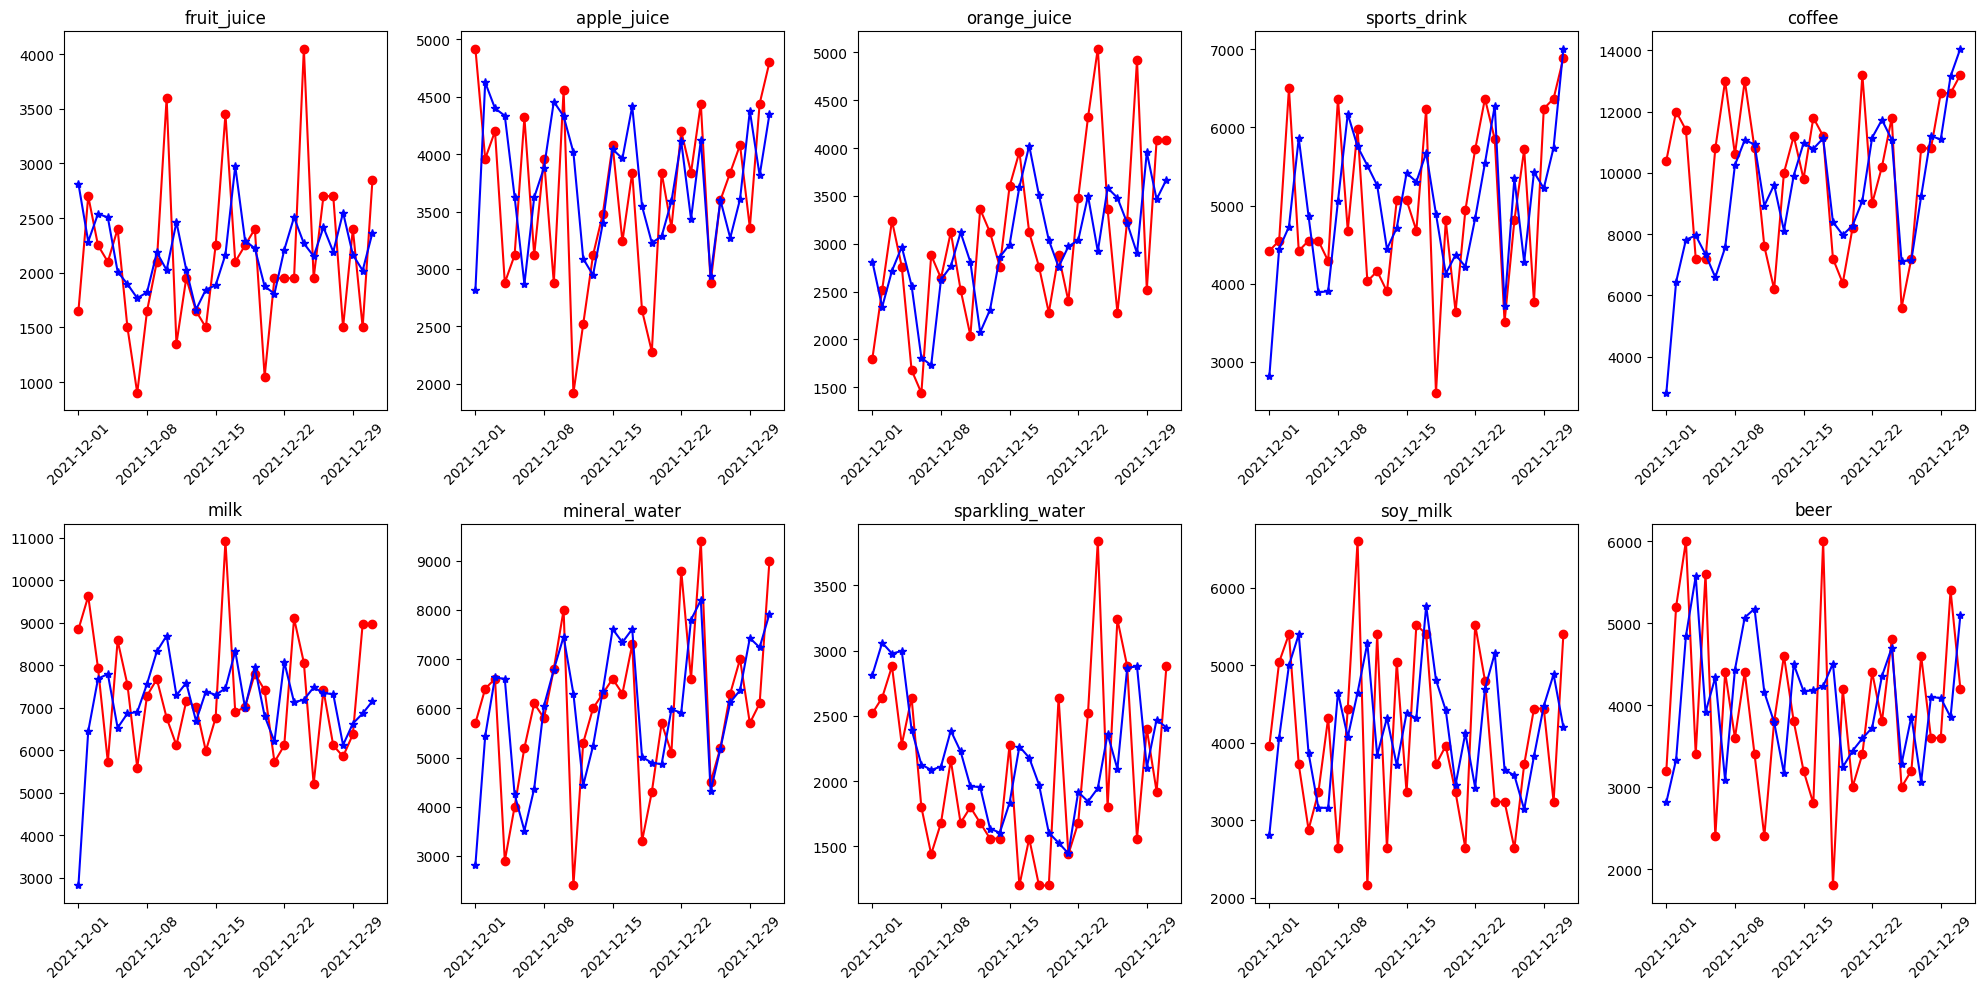

In [342]:
fig, axes = plt.subplots(2,5, figsize=(20, 10))
for ind, ax in enumerate(axes.flat):
    # print(ax, ind)
    select_item = item_lst[ind]
    to_plot = df_test_chiba.query("item == @select_item")
    ax.plot(to_plot["date"], to_plot["total_sales_amount"], color="r", marker="o")
    ax.plot(to_plot["date"], to_plot["prediction"], color="b", marker="*")
    xticks = to_plot["date"][::7].astype(str).values
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)
    ax.set_title(select_item);
plt.tight_layout()